this scrip based on feature3.ipynb

train on day8, validate on day9 with/wo potential_fraud


In [1]:
import pandas as pd 
import gc
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import time

In [2]:
with pd.HDFStore('../input/feat/feat3_trn_day8_val_day9.h5') as store:
    print(store.keys())
    train_df = store['train_df']
    val_df = store['valid_df']
    test_df = store['test_df']

['/test_df', '/train_df', '/valid_df']


In [3]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(62360949, 24)
shape of val  :(62832642, 24)
shape of test :(18790469, 24)


In [4]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgvalid], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

In [5]:
val_df = val_df[val_df.ip_lt126420==1]

In [6]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(62360949, 24)
shape of val  :(51222594, 24)
shape of test :(18790469, 24)


In [7]:
# print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.20,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200 # because training data is extremely unbalanced 
}

target = 'is_attributed'
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day','newip','ip_lt126420']

predictors = list(val_df.columns)
remove_col = ['click_id','click_time','is_attributed']
predictors = [e for e in predictors if e not in remove_col]

In [8]:
print('numbers of features', len(predictors))
predictors

numbers of features 21


['app',
 'channel',
 'day',
 'device',
 'hour',
 'ip',
 'newip',
 'os',
 'channel_nunique_ip',
 'hour_nunique_ip_day',
 'app_nunique_ip',
 'app_nunique_channel',
 'app_nunique_ip_device_os',
 'channel_cnt_ip_app',
 'next_click_dt',
 'ip_mean_target',
 'app_mean_target',
 'channel_mean_target',
 'os_mean_target',
 'device_mean_target',
 'ip_lt126420']

In [9]:
(bst,best_iteration) = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1000, 
                        categorical_features=categorical)

preparing validation datasets


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.940988
[20]	valid's auc: 0.95335
[30]	valid's auc: 0.958268
[40]	valid's auc: 0.96075
[50]	valid's auc: 0.962055
[60]	valid's auc: 0.962939
[70]	valid's auc: 0.963728
[80]	valid's auc: 0.964172
[90]	valid's auc: 0.964565
[100]	valid's auc: 0.9648
[110]	valid's auc: 0.964981
[120]	valid's auc: 0.965303
[130]	valid's auc: 0.96541
[140]	valid's auc: 0.965579
[150]	valid's auc: 0.96572
[160]	valid's auc: 0.965794
[170]	valid's auc: 0.965826
[180]	valid's auc: 0.965891
[190]	valid's auc: 0.965917
[200]	valid's auc: 0.965917
[210]	valid's auc: 0.965811
[220]	valid's auc: 0.965843
Early stopping, best iteration is:
[197]	valid's auc: 0.965938

Model Report
bst1.best_iteration:  197
auc: 0.965938046085


# Sub 
- baseline 

Plot feature importances...


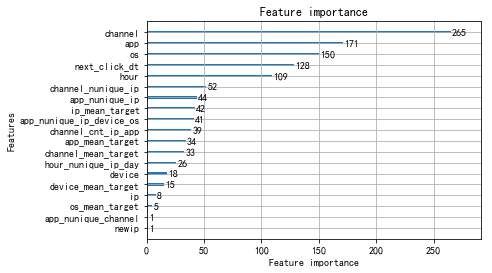

In [10]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100,importance_type='split')

In [11]:
pd.DataFrame({'f':bst.feature_name(),'score':bst.feature_importance(importance_type='gain')}).sort_values(by='score',ascending=False)

,f,score
16,app_mean_target,1.219015e+08
0,app,1.648685e+07
17,channel_mean_target,1.211488e+07
14,next_click_dt,8.081073e+06
10,app_nunique_ip,4.371795e+06
1,channel,3.672792e+06
7,os,3.138400e+06
8,channel_nunique_ip,2.412231e+06
9,hour_nunique_ip_day,2.071986e+06
13,channel_cnt_ip_app,1.380110e+06


In [13]:
bst.save_model('../output/model/lgb_val_98199_on_day9.txt')

In [14]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype(int)

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
print('complete')    

Predicting...
complete


In [15]:
sub.dtypes

click_id           int32
is_attributed    float64
dtype: object

In [16]:
sub.head()

,click_id,is_attributed
0,0,0.243002
1,1,0.078160
2,2,0.005305
3,3,0.034904
4,4,0.058788


In [18]:
sub['click_id'] = sub.click_id.astype('uint32')
sub['is_attributed'] = sub.is_attributed.astype('float16')

In [20]:
print('writing...')
fileno = 4
sub.to_csv('../output/sub_it{}.csv.gz'.format(fileno),index=False,compression='gzip')
print('finished')

writing...
finished


_____

# Hyperopt 
parameter tuning 

some error occur should retrain

In [22]:
from hyperopt import fmin, tpe, hp, STATUS_OK,Trials
import numpy as np 


In [23]:
print("preparing validation datasets...")
dtrain = train_df 
dvalid = val_df

xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical,
                      free_raw_data=False
                      )
xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical,
                      free_raw_data=False
                      )

preparing validation datasets...


In [24]:
def lgbm_objective(params):
    t1 = time.time()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',        
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric' : 'auc'
    }
    
    lgb_params.update(params)
    evals_results = {}
    reg = lgb.train(lgb_params,
                    train_set = xgtrain,                    
                    valid_sets=[xgtrain, xgvalid], 
                    valid_names=['train','valid'],
                    evals_result = evals_results,
                    early_stopping_rounds = 30 ,                    
                    verbose_eval = 10) ## 
    auc = evals_results['valid']['auc'][reg.best_iteration-1]
    t2 = time.time()    
    sec = int((t2-t1) % 60)
    mins = int((t2-t1) // 60)
    print('training time : {} min {} sec ...'.format(mins,sec))
    print('params:{}'.format(params))
    
    print('auc:{:.5f}'.format(reg.best_score['valid']['auc']))
    print('best iteration:{}'.format(reg.best_iteration))
    
    print('-------------'*5)
    
    return {'loss':1-reg.best_score['valid']['auc'], 'status': STATUS_OK }

In [21]:
# params = {
#     'learning_rate': 0.20,
#     #'is_unbalance': 'true', # replaced with scale_pos_weight argument
#     'num_leaves': 7,  # 2^max_depth - 1
#     'max_depth': 3,  # -1 means no limit
#     'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
#     'max_bin': 100,  # Number of bucketed bin for feature values
#     'subsample': 0.7,  # Subsample ratio of the training instance.
#     'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
#     'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
#     'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
#     'scale_pos_weight':200 # because training data is extremely unbalanced 
# }

In [25]:
lgbm_space = {
#     'boosting_type'   : hp.choice('boosting_type',['gbdt', 'dart']), ## gbdt 
    'boosting_type'   : 'gbdt',  
    'max_depth'       : hp.choice("max_depth", np.arange(5, 10, dtype=int)),
    'num_leaves'      : hp.choice('num_leaves', np.arange(32, 1024,100, dtype=int)), ## no limit     
    'learning_rate'   : hp.uniform('learning_rate', 0.1, 0.3),
    'num_boost_round' : 1000, ## num_iterations    
    'min_data_in_leaf': 100, ## prevent overfit
    'max_bin'         : hp.choice('max_bin', np.arange(50,150,10,dtype=int)),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0), ## colsample_bytree
    'bagging_fraction': hp.uniform ('bagging_fraction', 0.7, 1), ## subsample, can be used to speed up training/ deal with overfitting
    'reg_lambda'      : hp.uniform('reg_lambda',0,0.1),
    'gamma'           : hp.uniform('gamma', 0, 0.1),    
    'min_child_weight': hp.uniform('min_child_weight', 0, 0.1),
    'scale_pos_weight': hp.uniform('scale_pos_weight',100,300) 
}

In [49]:
trials = Trials()
best =fmin(fn = lgbm_objective,
           space = lgbm_space,
           algo = tpe.suggest,
           trials = trials,
           max_evals = 50
           )

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.978075	valid's auc: 0.973551
[20]	train's auc: 0.9815	valid's auc: 0.975821
[30]	train's auc: 0.98496	valid's auc: 0.976621
[40]	train's auc: 0.986554	valid's auc: 0.976923
[50]	train's auc: 0.987715	valid's auc: 0.976989
[60]	train's auc: 0.988475	valid's auc: 0.977094
[70]	train's auc: 0.989014	valid's auc: 0.97659
[80]	train's auc: 0.989529	valid's auc: 0.976005
[90]	train's auc: 0.989874	valid's auc: 0.975939
Early stopping, best iteration is:
[64]	train's auc: 0.98861	valid's auc: 0.977281
training time : 12 min 55 sec ...
params:{'bagging_fraction': 0.9026174232365477, 'boosting_type': 'gbdt', 'feature_fraction': 0.9306454011169665, 'gamma': 0.01286047674411317, 'learning_rate': 0.17941396849217645, 'max_bin': 100, 'max_depth': 5, 'min_child_weight': 0.08042663724297645, 'min_data_in_leaf': 100, 'num_boost_round': 1000, 'num_leaves': 232, 'reg_lambda': 0.0031614342595856606, 'scale_pos_weight': 142.

[70]	train's auc: 0.991824	valid's auc: 0.978027
Early stopping, best iteration is:
[44]	train's auc: 0.989689	valid's auc: 0.978158
training time : 12 min 13 sec ...
params:{'bagging_fraction': 0.9621797794956475, 'boosting_type': 'gbdt', 'feature_fraction': 0.5427364387065381, 'gamma': 0.08996745167734252, 'learning_rate': 0.1718066824191884, 'max_bin': 130, 'max_depth': 7, 'min_child_weight': 0.03089863310023159, 'min_data_in_leaf': 100, 'num_boost_round': 1000, 'num_leaves': 832, 'reg_lambda': 0.021898702840847963, 'scale_pos_weight': 233.28960894787565}
auc:0.97816
best iteration:44
-----------------------------------------------------------------
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.979826	valid's auc: 0.97512
[20]	train's auc: 0.985025	valid's auc: 0.977424
[30]	train's auc: 0.987475	valid's auc: 0.975906
[40]	train's auc: 0.988476	valid's auc: 0.976483
[50]	train's auc: 0.989306	valid's auc: 0.976563
Early stopping, best iteration is

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.982851	valid's auc: 0.976793
[20]	train's auc: 0.987576	valid's auc: 0.978024
[30]	train's auc: 0.990299	valid's auc: 0.977738
[40]	train's auc: 0.991241	valid's auc: 0.977379
[50]	train's auc: 0.992121	valid's auc: 0.977372
Early stopping, best iteration is:
[20]	train's auc: 0.987576	valid's auc: 0.978024
training time : 8 min 4 sec ...
params:{'bagging_fraction': 0.9642306388252234, 'boosting_type': 'gbdt', 'feature_fraction': 0.6892037054461706, 'gamma': 0.0529417453005204, 'learning_rate': 0.2867586646211837, 'max_bin': 120, 'max_depth': 7, 'min_child_weight': 0.006172812609331269, 'min_data_in_leaf': 100, 'num_boost_round': 1000, 'num_leaves': 332, 'reg_lambda': 0.07234113919203118, 'scale_pos_weight': 106.41089436715079}
auc:0.97802
best iteration:20
-----------------------------------------------------------------
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.98

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.982812	valid's auc: 0.976193
[20]	train's auc: 0.987643	valid's auc: 0.97779
[30]	train's auc: 0.990553	valid's auc: 0.978125
[40]	train's auc: 0.992156	valid's auc: 0.977614
[50]	train's auc: 0.992922	valid's auc: 0.97734
[60]	train's auc: 0.993803	valid's auc: 0.97643
Early stopping, best iteration is:
[30]	train's auc: 0.990553	valid's auc: 0.978125
training time : 11 min 14 sec ...
params:{'bagging_fraction': 0.8264499447693788, 'boosting_type': 'gbdt', 'feature_fraction': 0.5990289648894737, 'gamma': 0.06275873269757255, 'learning_rate': 0.21299399676100023, 'max_bin': 90, 'max_depth': 8, 'min_child_weight': 0.0011864225663258297, 'min_data_in_leaf': 100, 'num_boost_round': 1000, 'num_leaves': 632, 'reg_lambda': 0.012200917183420685, 'scale_pos_weight': 113.18388230593773}
auc:0.97813
best iteration:30
-----------------------------------------------------------------
Training until validation scores 

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.983396	valid's auc: 0.976628
[20]	train's auc: 0.987618	valid's auc: 0.977966
[30]	train's auc: 0.990845	valid's auc: 0.97818
[40]	train's auc: 0.992939	valid's auc: 0.977973
[50]	train's auc: 0.994036	valid's auc: 0.9781
[60]	train's auc: 0.995145	valid's auc: 0.977743
Early stopping, best iteration is:
[30]	train's auc: 0.990845	valid's auc: 0.97818
training time : 13 min 1 sec ...
params:{'bagging_fraction': 0.8452036836971826, 'boosting_type': 'gbdt', 'feature_fraction': 0.5413705637687718, 'gamma': 0.04900652616106786, 'learning_rate': 0.1680426423110845, 'max_bin': 140, 'max_depth': 9, 'min_child_weight': 0.024247128796003756, 'min_data_in_leaf': 100, 'num_boost_round': 1000, 'num_leaves': 632, 'reg_lambda': 0.03724401498009546, 'scale_pos_weight': 115.95864002472494}
auc:0.97818
best iteration:30
-----------------------------------------------------------------
Training until validation scores don'

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.983193	valid's auc: 0.976721
[20]	train's auc: 0.986456	valid's auc: 0.97759
[30]	train's auc: 0.98925	valid's auc: 0.977682
[40]	train's auc: 0.991216	valid's auc: 0.977369
[50]	train's auc: 0.992346	valid's auc: 0.97721
[60]	train's auc: 0.993219	valid's auc: 0.976586
Early stopping, best iteration is:
[38]	train's auc: 0.990742	valid's auc: 0.977957
training time : 13 min 59 sec ...
params:{'bagging_fraction': 0.8022841605841505, 'boosting_type': 'gbdt', 'feature_fraction': 0.773446138668554, 'gamma': 0.05955197796096068, 'learning_rate': 0.1488673612746569, 'max_bin': 110, 'max_depth': 9, 'min_child_weight': 0.09981404271294203, 'min_data_in_leaf': 100, 'num_boost_round': 1000, 'num_leaves': 132, 'reg_lambda': 0.04897600048970226, 'scale_pos_weight': 211.00642004730716}
auc:0.97796
best iteration:38
-----------------------------------------------------------------
Training until validation scores don'

In [50]:
1-np.min(trials.losses())

0.97884474804968158

* best AUC : 0.9788

In [53]:
best_params = {
    'bagging_fraction': 0.837509175752325,
    'boosting_type': 'gbdt', 
    'feature_fraction': 0.6082912220516488, 
    'gamma': 0.06433492702392277, 
    'learning_rate': 0.10168315534779368, 
    'max_bin': 90, 
    'max_depth': 8,
    'min_child_weight': 0.03936858598491562,
    'min_data_in_leaf': 100,
    'num_boost_round': 1000,
    'num_leaves': 632,
    'reg_lambda': 0.009974297912265825,
    'scale_pos_weight': 144.92491064993126
}

In [54]:
(bst,best_iteration) = lgb_modelfit_nocv(best_params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1000, 
                        categorical_features=categorical)

preparing validation datasets


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.981719	valid's auc: 0.975947
[20]	train's auc: 0.984006	valid's auc: 0.977522
[30]	train's auc: 0.985825	valid's auc: 0.978026
[40]	train's auc: 0.987963	valid's auc: 0.978249
[50]	train's auc: 0.989305	valid's auc: 0.978519
[60]	train's auc: 0.990675	valid's auc: 0.977761
[70]	train's auc: 0.99175	valid's auc: 0.977318
[80]	train's auc: 0.992343	valid's auc: 0.977405
Early stopping, best iteration is:
[50]	train's auc: 0.989305	valid's auc: 0.978519

Model Report
bst1.best_iteration:  50
auc: 0.978518538165


# opt sub

Plot feature importances...


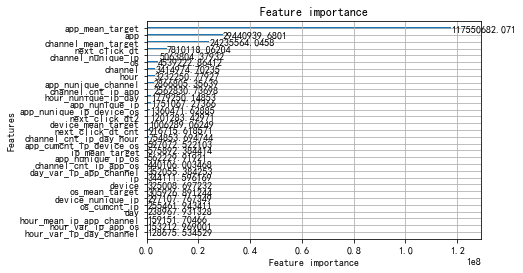

In [56]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100,importance_type='gain')

In [68]:
pd.DataFrame({'f':bst.feature_name(),'score':bst.feature_importance(importance_type='gain')}).sort_values(by='score',ascending=False)
# bst.feature_name()

,f,score
27,app_mean_target,"117,550,682.0708655"
0,app,"29,440,939.6801472"
28,channel_mean_target,"24,235,564.0457720"
23,next_click_dt,"7,810,118.0620446"
9,channel_nunique_ip,"5,063,804.3793187"
6,os,"4,539,222.8641224"
1,channel,"3,414,974.7023525"
4,hour,"3,232,250.7792749"
14,app_nunique_channel,"2,866,805.3563875"
17,channel_cnt_ip_app,"2,562,830.7369835"


In [69]:
bst.save_model('../output/model/lgb_opt_val_9785.txt')

In [70]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype(int)

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
print('complete')

Predicting...
complete


In [71]:
print('writing...')
fileno = 4
final_sub.to_csv('../output/sub_it{}.csv.gz'.format(fileno),index=False,compression='gzip')
print('finished')

writing...
finished
